In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
def find_intersection_nums(full_set, sets):

    result_set = full_set

    for set_ in sets:
        result_set = result_set.intersection(set_)

    return len(result_set)


def estimate_nums_prots(patient_data):

    patient_data_ordered = patient_data.sort_values(by='visit_month')
    months = np.sort(patient_data_ordered.visit_month.unique())

    nums_prots = patient_data_ordered \
        .groupby('visit_id') \
        .apply(lambda x: x.UniProt.nunique())

    prots = patient_data_ordered \
        .groupby('visit_id') \
        .apply(lambda x: x.UniProt.unique()) \
        .values

    prots = [set(prot) for prot in prots]
    nums_prots_df = pd.DataFrame({col_name: [val] for col_name, val
                                  in zip(months, nums_prots)})
    return nums_prots_df


def estimate_nums_peps(patient_data):

    patient_data_ordered = patient_data \
        .sort_values(by='visit_month')
    nums_peps = patient_data_ordered \
        .groupby(['visit_month', 'UniProt']) \
        .apply(lambda x: x.Peptide.nunique())

    months = [m[0] for m in nums_peps.index.values]
    nums_peps_df = pd.DataFrame({'visit_month': months,
                                 'vals': nums_peps})
    return nums_peps_df


def estimate_intersection(patient_data, intersection_col):

    vals = patient_data.groupby('visit_id') \
        .apply(lambda x: x[intersection_col]
               .unique()) \
        .values

    sets = [set(val) for val in vals]
    lens = [len(val) for val in vals]
    min_len = min(lens)
    full_set = set(patient_data[intersection_col].unique())
    intersection_nums = find_intersection_nums(full_set, sets)
    intersection_ratio = intersection_nums / min_len * 100
    return intersection_ratio

## Reading input data

In [3]:
peptides = pd.read_csv('../data/raw/train_peptides.csv')
proteins = pd.read_csv('../data/raw/train_proteins.csv')
clinical = pd.read_csv('../data/raw/train_clinical_data.csv')

In [4]:
print(clinical.shape, 
      proteins.shape, 
      peptides.shape)

(2615, 8) (232741, 5) (981834, 6)


In [22]:
peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [23]:
proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [24]:
clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


## Missing values

In [4]:
peptides.isna().sum() / len(peptides) * 100

visit_id            0.0
visit_month         0.0
patient_id          0.0
UniProt             0.0
Peptide             0.0
PeptideAbundance    0.0
dtype: float64

In [5]:
proteins.isna().sum() / len(proteins) * 100

visit_id       0.0
visit_month    0.0
patient_id     0.0
UniProt        0.0
NPX            0.0
dtype: float64

In [13]:
clinical.isna().sum() / len(clinical) * 100

visit_id                                0.000000
patient_id                              0.000000
visit_month                             0.000000
updrs_1                                 0.038241
updrs_2                                 0.076482
updrs_3                                 0.956023
updrs_4                                39.694073
upd23b_clinical_state_on_medication    50.745698
dtype: float64

There are some missing values in traget data

## Merge analysis

Let's see how many visit ids every table has

In [6]:
print(clinical.visit_id.nunique(), 
      proteins.visit_id.nunique(), 
      peptides.visit_id.nunique())

2615 1113 1113


Let's merge proteins and peptides and look at the size of resulting dataframe

In [16]:
peptides_proteins = peptides.merge(proteins, on=['visit_id', 'UniProt',
                                                 'visit_month', 'patient_id'])

In [17]:
print(peptides_proteins.shape, 
      peptides.shape)

(981834, 7) (981834, 6)


The resulting dataframe contains all info from both dataframes.

Let's see the intersection of visit ids between target data and peptides-proteins data

In [12]:
# The amount of visit ids from peptides-proteins data presenting in target data

peptides_proteins_visit_ids = pd.Series(peptides_proteins.visit_id.unique())
clinical_visit_ids = clinical.visit_id

print(peptides_proteins_visit_ids.isin(clinical_visit_ids).sum() /
      len(peptides_proteins_visit_ids) * 100)

95.95687331536388


In [13]:
# The amount of visit ids from target data presenting in peptides-proteins data

print(clinical_visit_ids.isin(peptides_proteins_visit_ids).sum() /
      len(clinical_visit_ids) * 100)

40.84130019120459


Let's see the intersection of patient ids between target data and peptides-proteins data

In [18]:
# The amount of patient ids from peptides-proteins data presenting in target data

peptides_proteins_patient_ids = pd.Series(peptides_proteins.patient_id.unique())
clinical_patient_ids = clinical.patient_id

print(peptides_proteins_patient_ids.isin(clinical_patient_ids).sum() / 
      len(peptides_proteins_patient_ids) * 100)

100.0


In [19]:
# The amount of patient ids from target data presenting in peptides-proteins data

print(clinical_patient_ids.isin(peptides_proteins_patient_ids).sum() /
      len(clinical_patient_ids) * 100)

100.0


In clinical data there's 40% of visits which have protein-peptide data.
However all the patients present both in clinical and protein data.

## Targets analysis

### Targets' distribution

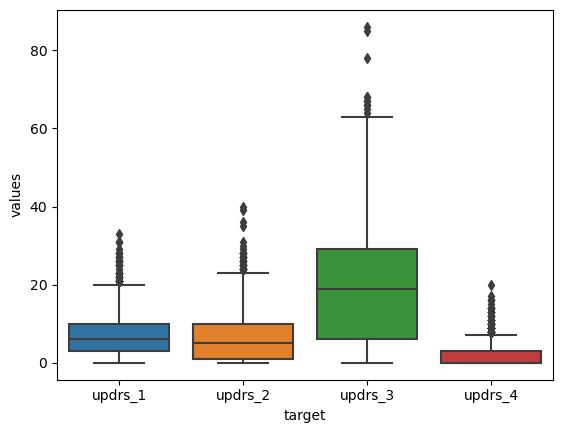

In [6]:
targets = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
dfs_updrs = [pd.DataFrame({'target': [target] * len(clinical),
                           'values': clinical[target]})
             for target in targets]

updrs_bp = pd.concat(dfs_updrs)
sns.boxplot(data=updrs_bp, x='target', y='values')
plt.show()

### Relationship between targets

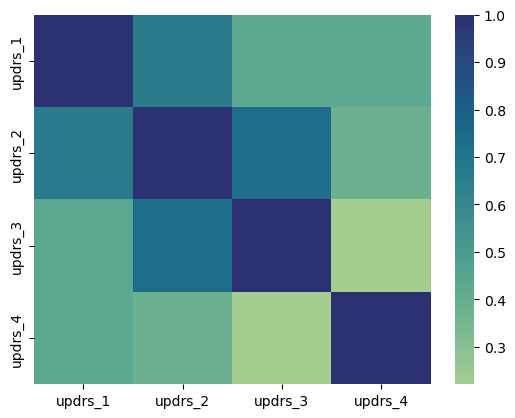

In [7]:
sns.heatmap(clinical[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].corr(),
            cmap="crest")
plt.show()

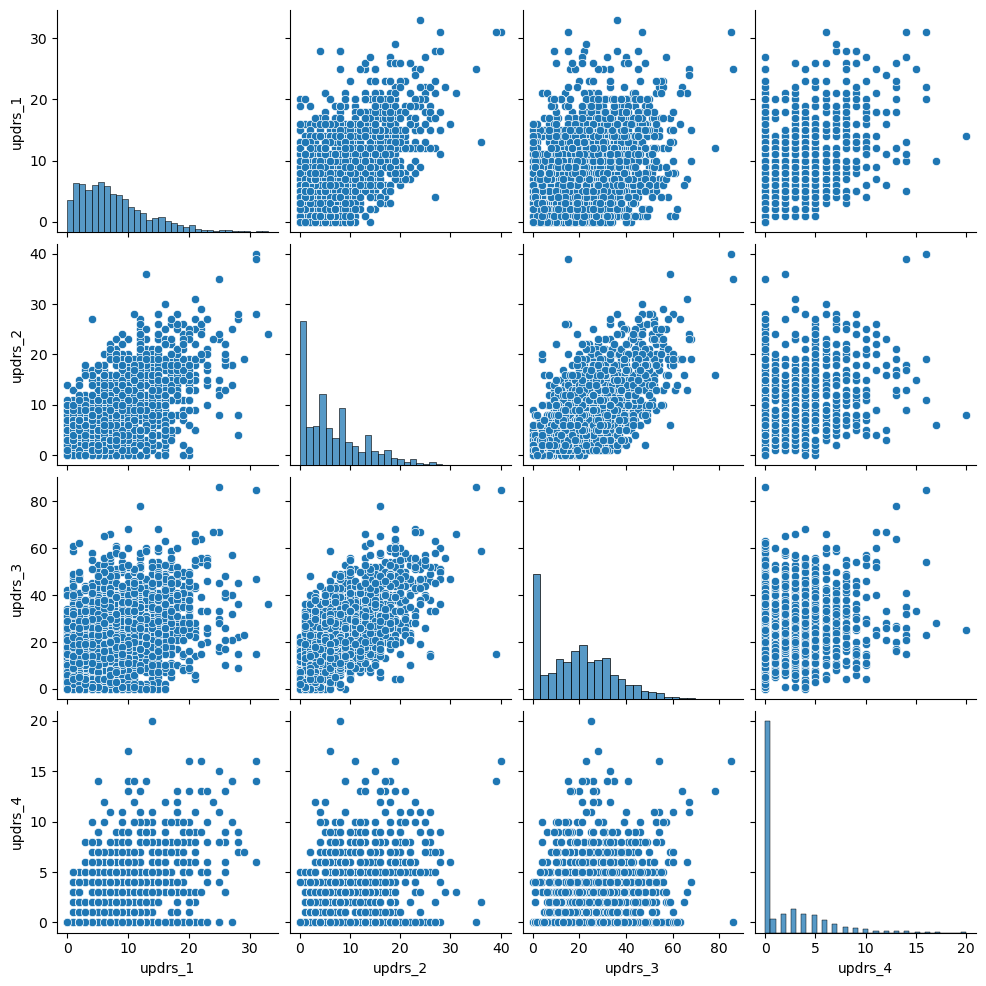

In [8]:
sns.pairplot(clinical[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']])
plt.show()

As we can see, updrs_1 and updrs_2, updrs_2 and updrs_3 respectively are correlated.

### Let's look how the targets change their values during the timeline

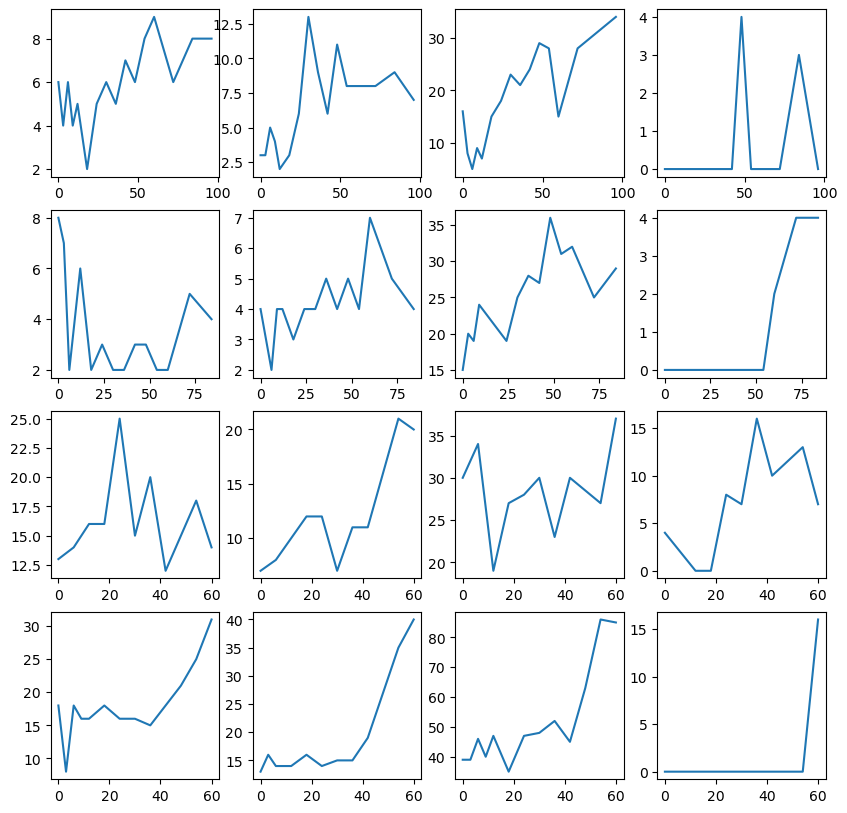

In [9]:
# here we take 4 random patients

patient_ids = np.random.choice(clinical.patient_id, 4)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, patient_id in enumerate(patient_ids):
    
    patient_data = clinical[clinical.patient_id == patient_id].fillna(0)
    axes[i, 0].plot(patient_data.visit_month, patient_data.updrs_1)
    axes[i, 1].plot(patient_data.visit_month, patient_data.updrs_2)
    axes[i, 2].plot(patient_data.visit_month, patient_data.updrs_3)
    axes[i, 3].plot(patient_data.visit_month, patient_data.updrs_4)

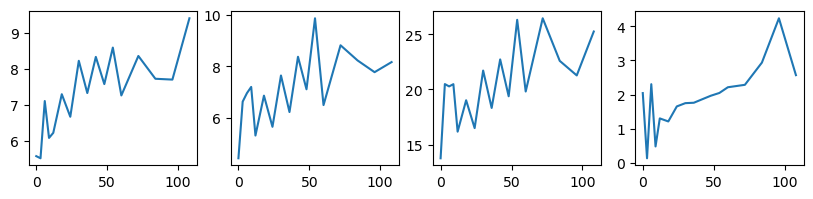

In [10]:
# Now let's take the average trend for all targets amoung all patients

avg_trends = clinical.groupby('visit_month')[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].apply(lambda x: x.mean())
fig, axes = plt.subplots(1, 4,  figsize=(10,2))

for i in range(4):
    axes[i].plot(avg_trends.index.values,
                 avg_trends['updrs_{}'.format(i+1)].values)

We can observe that the target values tend to increase during the timeline

## Protein analysis

Small sanity check

In [11]:
# check if there's no doubled prots per visit

proteins.groupby('visit_id') \
    .apply(lambda x: x.UniProt.nunique() / len(x)) \
    .value_counts()

# there's no doubled prots per visit

1.0    1113
dtype: int64

Let's estimate changing of protein number for patients

In [13]:
nums_prots = proteins \
    .groupby('patient_id') \
    .apply(lambda x: estimate_nums_prots(x))

nums_prots = nums_prots[np.sort(nums_prots.columns)]

intersection_ratio_prots = proteins \
    .groupby('patient_id') \
    .apply(lambda x: estimate_intersection(x, 'UniProt'))

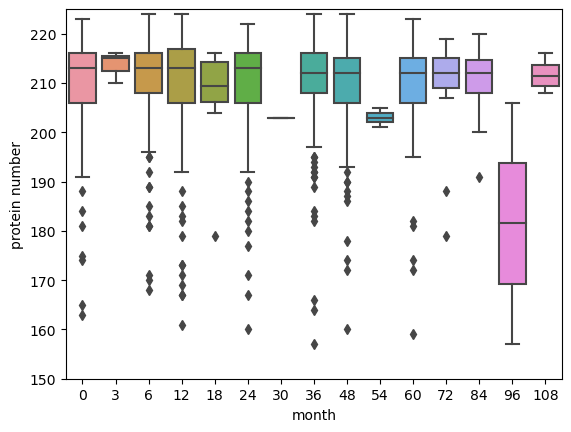

In [16]:
dfs_nums_prots = [pd.DataFrame({'month': [month] * len(nums_prots[month]),
                                'values': nums_prots[month]})
                  for month in nums_prots.columns]
nums_prots_bp = pd.concat(dfs_nums_prots)
ax = sns.boxplot(data=nums_prots_bp, x='month', y='values')
ax.set_ylim([150, 225])
ax.set_ylabel('protein number')
plt.show()

It's almost impossible to catch any trend in changing of protein number.

Let's estimate distrubution of proteins' intersection ratio.

/home/max/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


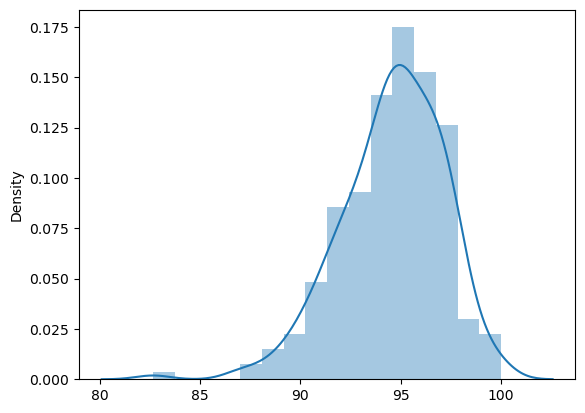

In [17]:
sns.distplot(intersection_ratio_prots)
plt.show()

During the visits, protein sets for a patient still almost the same, apparently, because for each visit number of estimated prots is close to number of all unique prots in dataset

## Peptide analysis

Some sanity checks

In [18]:
# check if there're no doubled pepts per prot-visit

peptides.groupby(['visit_id', 'UniProt']) \
    .apply(lambda x: x.Peptide.nunique() / len(x)) \
    .value_counts()

# there's no doubled prots pepts per prot-visit

1.0    232741
dtype: int64

In [19]:
# check if there're no doubled pepts per visit

peptides.groupby(['visit_id']) \
    .apply(lambda x: x.Peptide.nunique() / len(x)) \
    .value_counts()

# there's no doubled prots pepts per visit

1.0    1113
dtype: int64

In [20]:
# check if there're several prots per peptides
peptides.groupby(['Peptide']) \
    .apply(lambda x: x.UniProt.nunique()) \
    .value_counts()

# there's only one prot per peptides

1    968
dtype: int64

Let's estimate distrubution of peptides' number for all possible combinations of visits and proteins

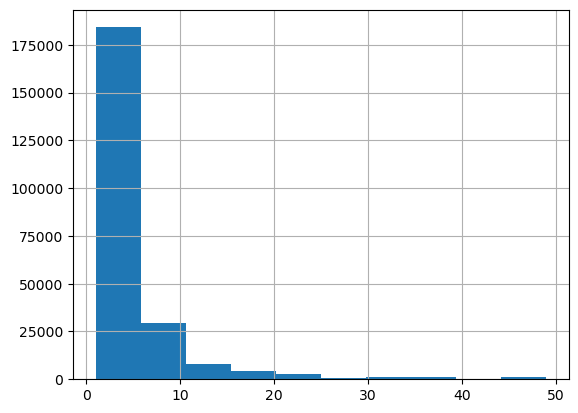

In [21]:
peptides.groupby(['visit_id', 'UniProt']) \
    .apply(lambda x: x.Peptide.nunique()) \
    .hist()
plt.show()

Let's estimate distrubution of peptides' number for all proteins

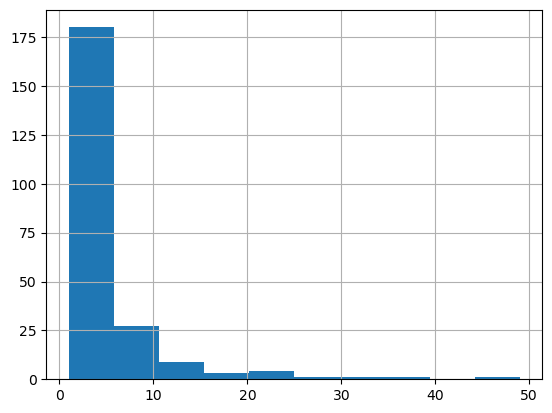

In [22]:
peptides.groupby('UniProt').apply(lambda x: x.Peptide.nunique()).hist()
plt.show()

Two distributions look almost the same.

Every protein has from 1 to 50 unique peptide values.

Let's estimate changing of peptide number for patients for all possible combinations of visits and proteins.

In [37]:
nums_pepts = peptides.groupby('patient_id').apply(lambda x: estimate_nums_peps(x))

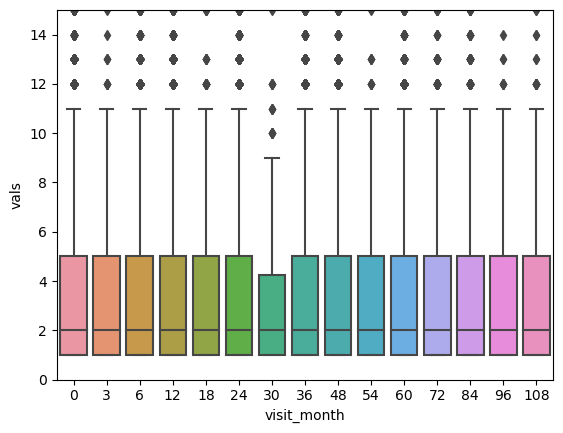

In [24]:
ax = sns.boxplot(data=nums_pepts, x='visit_month', y='vals')
ax.set_ylim([0, 15])   
plt.show()

There's no linear trend in changing of number of estimated pepts per prots.

Let's estimate distrubution of peptides' intersection ratio for all possible combinations of visits and proteins.

In [25]:
intersection_ratio_peps = peptides.groupby(['patient_id', 'UniProt']) \
    .apply(lambda x: estimate_intersection(x, 'Peptide'))

/home/max/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


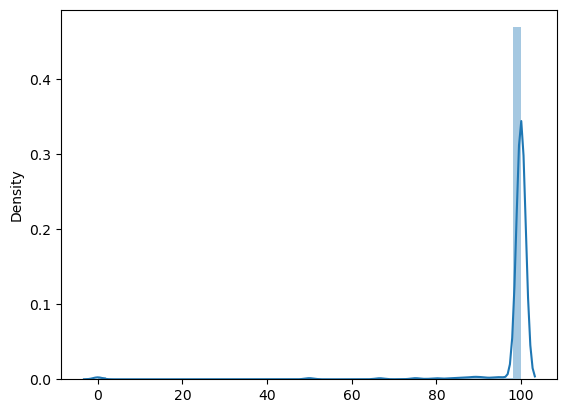

In [26]:
sns.distplot(intersection_ratio_peps)
plt.show()

In [32]:
# Percentage of 100% intersection ratios

intersection_ratio_peps_vc = intersection_ratio_peps.value_counts()
intersection_ratio_peps_vc_100 = \
    intersection_ratio_peps_vc[intersection_ratio_peps_vc.index >= 100] / \
    intersection_ratio_peps_vc.sum() * 100
print(intersection_ratio_peps_vc_100)

# 93% of patient's prots don't change their pepts sets during the visits.

100.0    93.791195
dtype: float64


## The analysis of the sequences of amino acids

In [33]:
# aggregate all sequence in one string

agg_string = peptides['Peptide'].unique().sum()

# exclude special UniMod part

excluded_unimod = re.sub(r'\(UniMod_[0-9]*\)', '', agg_string)
print(pd.Series(list(excluded_unimod)).unique())

['N' 'E' 'Q' 'P' 'L' 'G' 'W' 'H' 'S' 'T' 'F' 'K' 'I' 'V' 'A' 'Y' 'C' 'M'
 'R' 'D']


In [34]:
# all kinds of UniMod

unimods = re.findall(r'\(UniMod_[0-9]*\)', agg_string)
print(pd.Series(list(unimods)).unique())

['(UniMod_4)' '(UniMod_35)']


## Conclusion

We can conclude, that each patient has several visits. Each visit has a certain set of proteins, and then each protein related to this visit has its own set of peptides, which are represented as sequences of characters. So we need to find a way to gather and preprocess all the data in order to preserve all the information.